In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gsw

In [2]:
rootdir = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/'
datadir = 'ocean_annual_z_1x1deg/ts/annual/5yr/'
filename_age = 'ocean_annual_z_1x1deg.0951-0955.agessc.nc'
filename_temp = 'ocean_annual_z_1x1deg.0951-0955.thetao.nc'
filename_vol = 'ocean_annual_z_1x1deg.0951-0955.volcello.nc'
filename_so = 'ocean_annual_z_1x1deg.0951-0955.so.nc'

In [3]:
age = xr.open_dataset(rootdir + datadir + filename_age)
temp = xr.open_dataset(rootdir + datadir + filename_temp)
vol = xr.open_dataset(rootdir + datadir + filename_vol)
so = xr.open_dataset(rootdir + datadir + filename_so)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [4]:
potden = gsw.density.sigma2(so.so, temp.thetao)
lat = so.lat 
lon = so.lon
time = so.time
z_l = so.z_l

In [5]:
pot_den = xr.DataArray(potden, coords = [time, z_l, lat, lon ], dims = ['time', 'z_l', 'lat', 'lon'])
pot_den.name = 'Potential Density'

In [6]:
ds = xr.merge([temp, age, vol, so])
df = xr.merge([ds, pot_den])
print(df)

<xarray.Dataset>
Dimensions:            (bnds: 2, lat: 180, lon: 360, time: 5, z_i: 36, z_l: 35)
Coordinates:
  * lat                (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time               (time) object 0951-07-02 12:00:00 ... 0955-07-02 12:00:00
  * z_i                (z_i) float64 0.0 5.0 15.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l                (z_l) float64 2.5 10.0 20.0 ... 5.5e+03 6e+03 6.5e+03
Dimensions without coordinates: bnds
Data variables:
    average_DT         (time) timedelta64[ns] 365 days 365 days ... 365 days
    average_T1         (time) object 0950-05-09 00:00:00 ... 0954-05-08 00:00:00
    average_T2         (time) object 0951-05-09 00:00:00 ... 0955-05-08 00:00:00
    lat_bnds           (lat, bnds) float64 -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
    lon_bnds           (lon, bnds) float64 0.0 1.0 1.0 2.0 ... 359.0 359.0 360.0
    thetao             (time, z_l, la

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/num

In [7]:
pV = df.volcello*df.agessc
pV.name = 'pV'
df = xr.merge([df, pV])

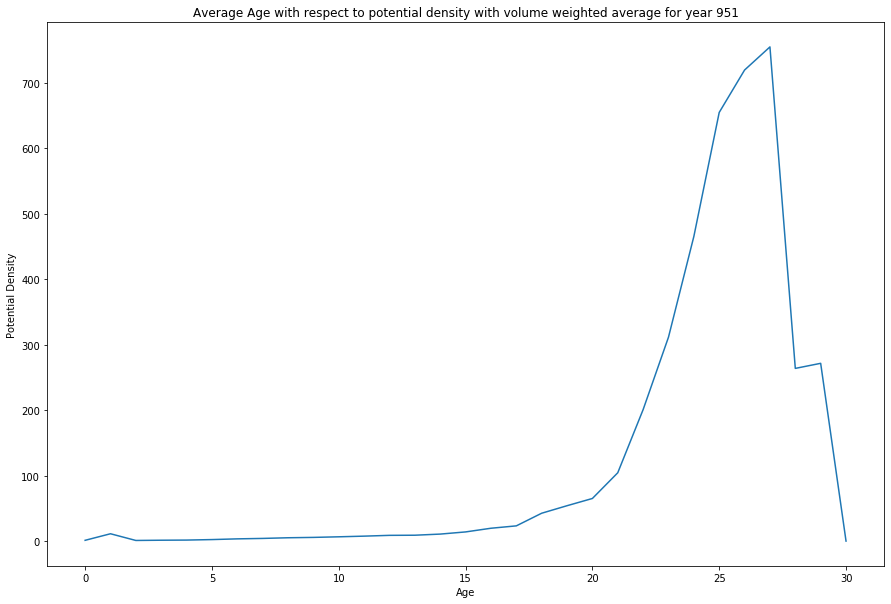

In [8]:
df = df.set_coords('Potential Density')
potden_bins = np.arange(30,38,.25)
pV_in_theta = df.pV.isel(time=0).groupby_bins('Potential Density', potden_bins)
V_in_theta = df.volcello.isel(time=0).groupby_bins('Potential Density',potden_bins)
# Seperate Sections
pv_mean = pV_in_theta.sum(xr.ALL_DIMS)/V_in_theta.sum(xr.ALL_DIMS)
plt.figure(figsize = (15,10))
plt.plot(pv_mean)
plt.title('Average Age with respect to potential density with volume weighted average for year 951')
plt.ylabel('Potential Density')
plt.xlabel('Age')
plt.show()

In [9]:
# Try to recover the range that we need to plot
potdenbin = []
for i in range(0, 31):
    potdenbin.append(30.0+(i+1)*0.25)
print(potdenbin)

[30.25, 30.5, 30.75, 31.0, 31.25, 31.5, 31.75, 32.0, 32.25, 32.5, 32.75, 33.0, 33.25, 33.5, 33.75, 34.0, 34.25, 34.5, 34.75, 35.0, 35.25, 35.5, 35.75, 36.0, 36.25, 36.5, 36.75, 37.0, 37.25, 37.5, 37.75]


In [10]:
# This section is specifically for calculating a weighted standard deviation 
# The formula we use is linked here https://stats.stackexchange.com/questions/6534/how-do-i-calculate-a-weighted-standard-deviation-in-excel in the top answer.
# One of the most troubling parts of it is that we can't just calculate the mean and then use it, since it will no longer have the same dimensions
# The first thing we will assign is the top part, which will have to be summed over every density space
vol = df.volcello.isel(time = 0)
age = df.agessc.isel(time =0)
top = vol * (age*vol/vol.sum(xr.ALL_DIMS) - age)**(2)
print(top)
a = top.groupby_bins('Potential Density', potden_bins)

<xarray.DataArray (z_l: 35, lat: 180, lon: 360)>
array([[[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
        ...,
        [ 2662567.8,  2681874.8, ...,  2596553.5,  2630441.5],
        [ 1728620.8,  1760224.4, ...,  1665422.2,  1697017.8]],

       [[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
        ...,
        [29027732. , 29600100. , ..., 27604166. , 28311928. ],
        [28412578. , 29218080. , ..., 26830366. , 27616654. ]],

       ...,

       [[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
        ...,
        [       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan]],

       [[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
        ...

In [11]:
# calculate the bottom part of the standard deviation equation
bottom = (V_in_theta.count(xr.ALL_DIMS)-1)/(V_in_theta.count(xr.ALL_DIMS))*V_in_theta.sum(xr.ALL_DIMS)
print(bottom)

<xarray.DataArray 'volcello' (Potential Density_bins: 31)>
array([5.823657e+14, 1.259328e+15, 9.450400e+14, 1.137201e+15, 1.093134e+15,
       1.220353e+15, 1.292320e+15, 1.265782e+15, 1.372204e+15, 1.497190e+15,
       1.767764e+15, 2.149392e+15, 2.520187e+15, 3.191899e+15, 3.669925e+15,
       4.423212e+15, 5.194398e+15, 7.716777e+15, 1.104052e+16, 1.721825e+16,
       2.816920e+16, 3.864295e+16, 4.169247e+16, 4.072359e+16, 5.172117e+16,
       7.999557e+16, 2.909850e+17, 6.348465e+17, 4.736806e+16, 9.437869e+15,
       4.642196e+11])
Coordinates:
  * Potential Density_bins  (Potential Density_bins) object (30.0, 30.25] ... (37.5, 37.75]
    time                    object 0951-07-02 12:00:00


In [12]:
# Calculating the square of the standard deviation 
var = a.sum(xr.ALL_DIMS)/((V_in_theta.count(xr.ALL_DIMS)-1)/(V_in_theta.count(xr.ALL_DIMS))*V_in_theta.sum(xr.ALL_DIMS))

In [13]:
print(var)

<xarray.DataArray (Potential Density_bins: 31)>
array([1.526475e+01, 3.326288e+02, 6.600111e+00, 1.088992e+01, 1.519475e+01,
       3.038737e+01, 5.179896e+01, 6.745608e+01, 1.070334e+02, 1.351996e+02,
       1.544362e+02, 2.136375e+02, 3.139150e+02, 2.775157e+02, 4.221441e+02,
       6.105276e+02, 1.062256e+03, 1.269984e+03, 7.698996e+03, 9.622904e+03,
       8.537297e+03, 2.061300e+04, 6.550558e+04, 1.417128e+05, 2.876614e+05,
       5.274645e+05, 6.523247e+05, 6.430172e+05, 7.848612e+04, 1.263515e+05,
       2.451418e-02])
Coordinates:
  * Potential Density_bins  (Potential Density_bins) object (30.0, 30.25] ... (37.5, 37.75]
    time                    object 0951-07-02 12:00:00


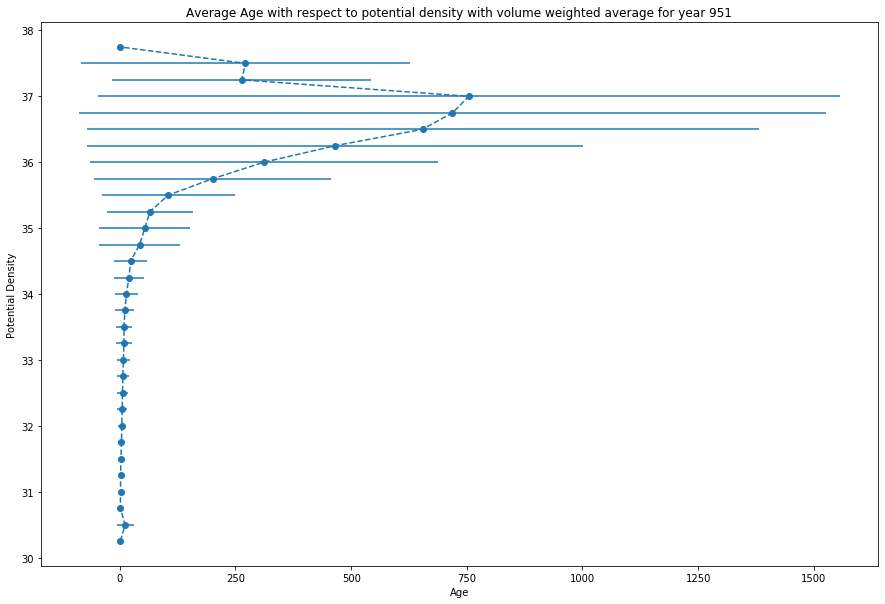

In [14]:
plt.figure(figsize = (15,10))
plt.errorbar(pv_mean, potdenbin, xerr = var**(0.5), marker = 'o', linestyle = '--')
plt.title('Average Age with respect to potential density with volume weighted average for year 951')
plt.ylabel('Potential Density')
plt.xlabel('Age')
plt.show()

In [15]:
print(var**(0.5))

<xarray.DataArray (Potential Density_bins: 31)>
array([3.907012e+00, 1.823811e+01, 2.569068e+00, 3.299987e+00, 3.898045e+00,
       5.512474e+00, 7.197149e+00, 8.213165e+00, 1.034570e+01, 1.162754e+01,
       1.242724e+01, 1.461634e+01, 1.771765e+01, 1.665880e+01, 2.054615e+01,
       2.470886e+01, 3.259227e+01, 3.563684e+01, 8.774392e+01, 9.809640e+01,
       9.239750e+01, 1.435723e+02, 2.559406e+02, 3.764476e+02, 5.363407e+02,
       7.262675e+02, 8.076662e+02, 8.018835e+02, 2.801537e+02, 3.554595e+02,
       1.565701e-01])
Coordinates:
  * Potential Density_bins  (Potential Density_bins) object (30.0, 30.25] ... (37.5, 37.75]
    time                    object 0951-07-02 12:00:00


In [16]:
# Let's compare that to depth! 
dataset = df
dataset = dataset.set_coords('z_l')
depth_bins = dataset.z_l
pV_in_theta = dataset.pV.isel(time=0).groupby_bins('z_l', depth_bins)
V_in_theta = dataset.volcello.isel(time=0).groupby_bins('z_l',depth_bins)
# Seperate Sections
pv_mean2 = pV_in_theta.sum(xr.ALL_DIMS)/V_in_theta.sum(xr.ALL_DIMS)


In [17]:
newdepth_bins = depth_bins[1:]
print(depth_bins)
newtop = vol * (age*vol/vol.sum(xr.ALL_DIMS) - age)**(2)
print(newtop)
b = newtop.groupby_bins('z_l', depth_bins)

<xarray.DataArray 'z_l' (z_l: 35)>
array([2.5000e+00, 1.0000e+01, 2.0000e+01, 3.2500e+01, 5.1250e+01, 7.5000e+01,
       1.0000e+02, 1.2500e+02, 1.5625e+02, 2.0000e+02, 2.5000e+02, 3.1250e+02,
       4.0000e+02, 5.0000e+02, 6.0000e+02, 7.0000e+02, 8.0000e+02, 9.0000e+02,
       1.0000e+03, 1.1000e+03, 1.2000e+03, 1.3000e+03, 1.4000e+03, 1.5375e+03,
       1.7500e+03, 2.0625e+03, 2.5000e+03, 3.0000e+03, 3.5000e+03, 4.0000e+03,
       4.5000e+03, 5.0000e+03, 5.5000e+03, 6.0000e+03, 6.5000e+03])
Coordinates:
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
Attributes:
    long_name:  Depth at cell center
    units:      meters
    axis:       Z
    positive:   down
    edges:      z_i
<xarray.DataArray (z_l: 35, lat: 180, lon: 360)>
array([[[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
        ...,
        [ 2662567.8,  2681874.8, ...,  2596553.5,  2630441.5],
        [ 1728620.8,  1760224

In [18]:
newbottom = (V_in_theta.count(xr.ALL_DIMS)-1)/(V_in_theta.count(xr.ALL_DIMS))*V_in_theta.sum(xr.ALL_DIMS)
print(newbottom)

<xarray.DataArray 'volcello' (z_l_bins: 34)>
array([3.597720e+15, 3.571220e+15, 5.318952e+15, 7.892952e+15, 8.673094e+15,
       8.601021e+15, 8.546279e+15, 1.274511e+16, 1.688471e+16, 1.678776e+16,
       2.502146e+16, 3.311204e+16, 3.287390e+16, 3.267216e+16, 3.250971e+16,
       3.236602e+16, 3.222822e+16, 3.208791e+16, 3.195348e+16, 3.181470e+16,
       3.166283e+16, 3.151064e+16, 5.477459e+16, 7.738446e+16, 1.138505e+17,
       1.465341e+17, 1.366512e+17, 1.194800e+17, 9.497788e+16, 6.568607e+16,
       3.687673e+16, 1.234491e+16, 1.781401e+15, 1.912249e+14])
Coordinates:
  * z_l_bins  (z_l_bins) object (2.5, 10.0] (10.0, 20.0] ... (6000.0, 6500.0]
    time      object 0951-07-02 12:00:00


In [19]:
# Calculate standard deviation squared
newvar = b.sum(xr.ALL_DIMS)/newbottom
print(newvar)

<xarray.DataArray (z_l_bins: 34)>
array([3.477000e+00, 1.571265e+01, 4.798955e+01, 1.386162e+02, 4.000324e+02,
       1.248327e+03, 3.373111e+03, 7.141869e+03, 1.210742e+04, 1.754233e+04,
       2.477862e+04, 3.758285e+04, 6.120382e+04, 9.937547e+04, 1.536882e+05,
       2.242093e+05, 3.061277e+05, 3.875418e+05, 4.585110e+05, 5.163587e+05,
       5.609218e+05, 5.919802e+05, 6.189595e+05, 6.435616e+05, 6.626608e+05,
       6.821572e+05, 7.016284e+05, 6.863221e+05, 6.267961e+05, 5.477092e+05,
       5.162450e+05, 5.846941e+05, 6.448546e+05, 6.467748e+05])
Coordinates:
  * z_l_bins  (z_l_bins) object (2.5, 10.0] (10.0, 20.0] ... (6000.0, 6500.0]
    time      object 0951-07-02 12:00:00


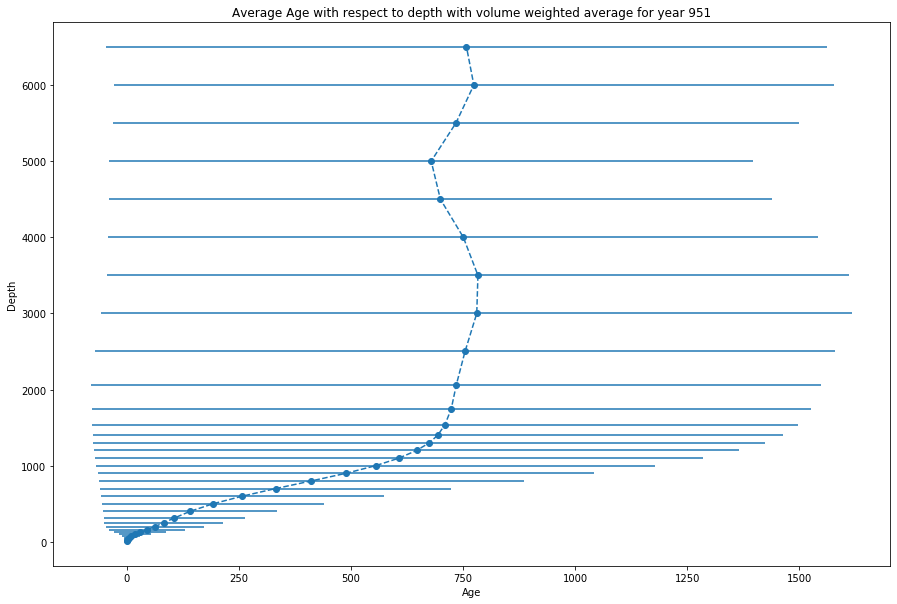

In [20]:
# Now plot the standard deviation with the weighted means!
plt.figure(figsize = (15,10))
plt.errorbar(pv_mean2, newdepth_bins, xerr = newvar**(0.5), marker = 'o', linestyle = '--')
plt.title('Average Age with respect to depth with volume weighted average for year 951')
plt.ylabel('Depth')
plt.xlabel('Age')
plt.show()

In [21]:
print(newdepth_bins)

<xarray.DataArray 'z_l' (z_l: 34)>
array([  10.  ,   20.  ,   32.5 ,   51.25,   75.  ,  100.  ,  125.  ,  156.25,
        200.  ,  250.  ,  312.5 ,  400.  ,  500.  ,  600.  ,  700.  ,  800.  ,
        900.  , 1000.  , 1100.  , 1200.  , 1300.  , 1400.  , 1537.5 , 1750.  ,
       2062.5 , 2500.  , 3000.  , 3500.  , 4000.  , 4500.  , 5000.  , 5500.  ,
       6000.  , 6500.  ])
Coordinates:
  * z_l      (z_l) float64 10.0 20.0 32.5 51.25 ... 5e+03 5.5e+03 6e+03 6.5e+03
Attributes:
    long_name:  Depth at cell center
    units:      meters
    axis:       Z
    positive:   down
    edges:      z_i


In [22]:
print(newvar**(0.5))

<xarray.DataArray (z_l_bins: 34)>
array([  1.864672,   3.963919,   6.927449,  11.77354 ,  20.000809,  35.331666,
        58.078494,  84.50958 , 110.033712, 132.447468, 157.412256, 193.862957,
       247.394059, 315.238747, 392.030926, 473.507479, 553.288115, 622.528542,
       677.134414, 718.581021, 748.947112, 769.40251 , 786.73977 , 802.222933,
       814.039803, 825.928075, 837.632627, 828.445578, 791.704562, 740.073768,
       718.501881, 764.652946, 803.028392, 804.223132])
Coordinates:
  * z_l_bins  (z_l_bins) object (2.5, 10.0] (10.0, 20.0] ... (6000.0, 6500.0]
    time      object 0951-07-02 12:00:00


In [23]:
print(pv_mean2)

<xarray.DataArray (z_l_bins: 34)>
array([5.499889e-01, 1.122262e+00, 2.203508e+00, 4.583970e+00, 9.435560e+00,
       1.772083e+01, 2.921226e+01, 4.408248e+01, 6.248855e+01, 8.177470e+01,
       1.054482e+02, 1.407630e+02, 1.920656e+02, 2.574901e+02, 3.320348e+02,
       4.113334e+02, 4.884594e+02, 5.547066e+02, 6.070225e+02, 6.461423e+02,
       6.743153e+02, 6.932845e+02, 7.094820e+02, 7.236577e+02, 7.348345e+02,
       7.542670e+02, 7.804246e+02, 7.830350e+02, 7.504703e+02, 6.992934e+02,
       6.788015e+02, 7.339421e+02, 7.739070e+02, 7.575226e+02], dtype=float32)
Coordinates:
  * z_l_bins  (z_l_bins) object (2.5, 10.0] (10.0, 20.0] ... (6000.0, 6500.0]
    time      object 0951-07-02 12:00:00


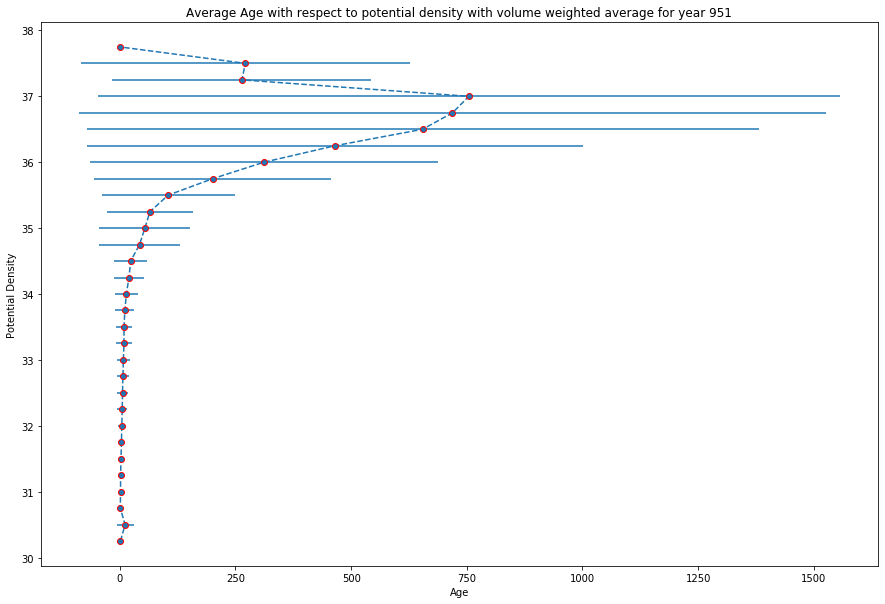

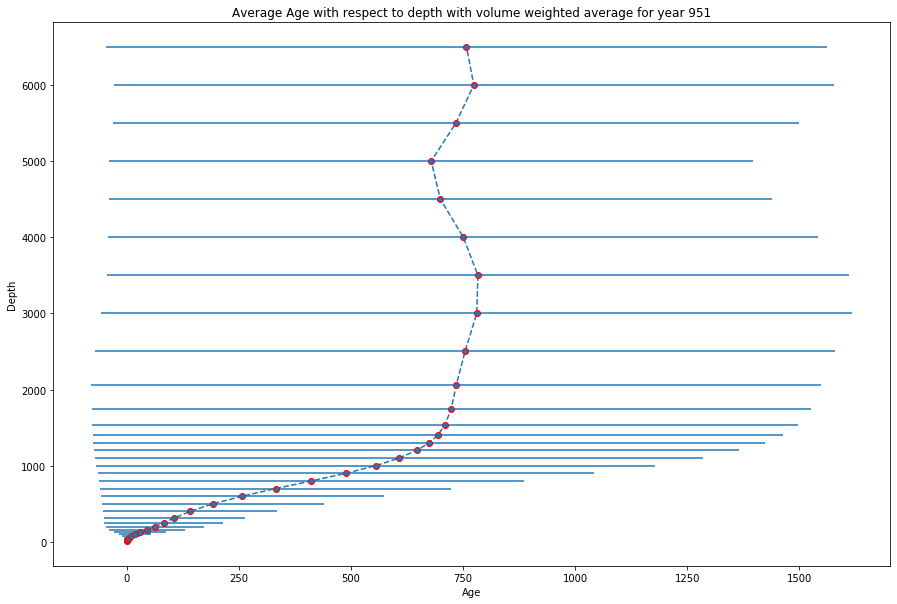

In [24]:
# Age vs. Potential Density
plt.figure(figsize = (15,10))
plt.errorbar(pv_mean, potdenbin, xerr = var**(0.5), marker = 'o', linestyle = '--', markeredgecolor = 'r')
plt.title('Average Age with respect to potential density with volume weighted average for year 951')
plt.ylabel('Potential Density')
plt.xlabel('Age')
plt.show()
# Age vs. Depth
plt.figure(figsize = (15,10))
plt.errorbar(pv_mean2, newdepth_bins, xerr = newvar**(0.5), marker = 'o', linestyle = '--', markeredgecolor = 'r')
plt.title('Average Age with respect to depth with volume weighted average for year 951')
plt.ylabel('Depth')
plt.xlabel('Age')
plt.show()

In [25]:
# You can see how using density can have less variations in age compared to looking at depth. 
# More analysis is probably needed but it is a good start regardless. 